Ep 000 | R=7.11 CVaR=0.87 C=0.48 μ=1.01 crashes=31
Ep 010 | R=8.59 CVaR=3.12 C=0.22 μ=1.10 crashes=14
Ep 020 | R=8.16 CVaR=1.98 C=0.30 μ=1.17 crashes=19
Ep 030 | R=7.68 CVaR=0.87 C=0.39 μ=1.24 crashes=25
Ep 040 | R=8.70 CVaR=2.95 C=0.23 μ=1.32 crashes=15
Ep 050 | R=8.54 CVaR=5.04 C=0.27 μ=1.39 crashes=17
Ep 060 | R=8.93 CVaR=3.22 C=0.11 μ=1.45 crashes=7
Ep 070 | R=8.66 CVaR=3.68 C=0.17 μ=1.50 crashes=11
Ep 080 | R=8.43 CVaR=3.26 C=0.23 μ=1.54 crashes=15
Ep 090 | R=8.94 CVaR=4.83 C=0.14 μ=1.58 crashes=9
Ep 100 | R=8.99 CVaR=4.03 C=0.11 μ=1.60 crashes=7
Ep 110 | R=9.04 CVaR=5.42 C=0.09 μ=1.62 crashes=6
Ep 120 | R=8.68 CVaR=3.84 C=0.14 μ=1.63 crashes=9
Ep 130 | R=9.18 CVaR=6.62 C=0.03 μ=1.64 crashes=2
Ep 140 | R=9.16 CVaR=5.71 C=0.08 μ=1.65 crashes=5
Ep 150 | R=9.17 CVaR=5.69 C=0.17 μ=1.65 crashes=11
Ep 160 | R=9.06 CVaR=5.84 C=0.23 μ=1.69 crashes=15
Ep 170 | R=8.89 CVaR=5.46 C=0.23 μ=1.73 crashes=15
Ep 180 | R=9.36 CVaR=5.77 C=0.12 μ=1.77 crashes=8
Ep 190 | R=9.44 CVaR=5.76 C=0.17 μ=1.80

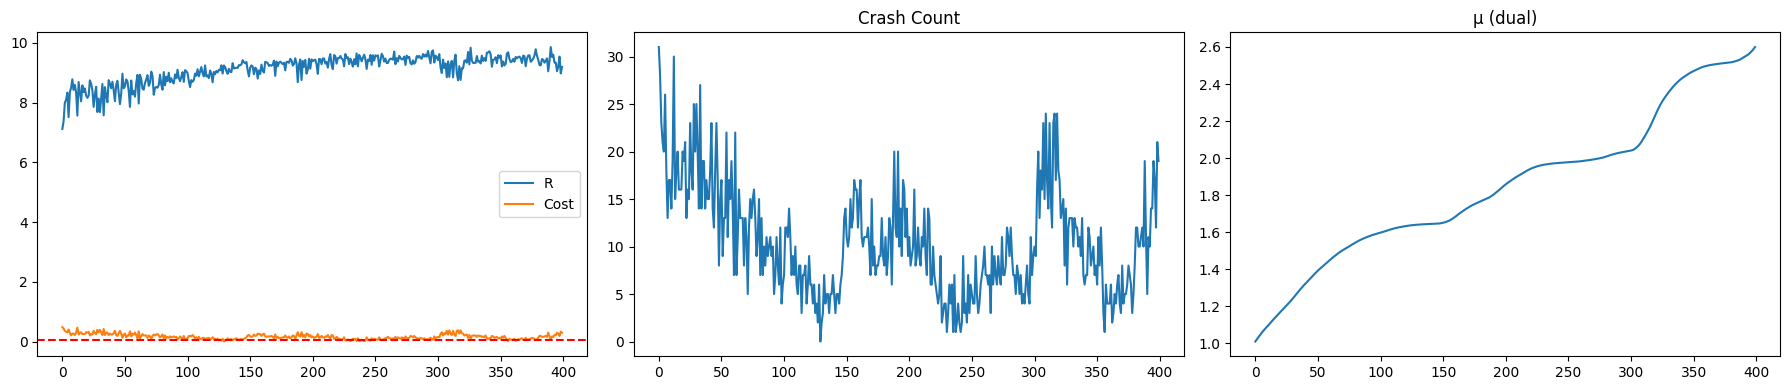

In [9]:
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv
import highway_env   # registers roundabout-v0
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

# 1) Kinematics obs config + feature→index map
kin_config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 15,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x":  [-100, 100],
            "y":  [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "order":    "sorted"
    }
}
feat2idx = {name: i for i, name in enumerate(kin_config["observation"]["features"])}
vx_idx   = feat2idx["vx"]
vy_idx   = feat2idx["vy"] 

# 2) Hyper-parameters
env_id        = "roundabout-v0"
batch_size    = 64
max_steps     = 300 # 200
hidden_size   = 256
gamma         = 0.99
alpha         = 0.05
cost_limit    = 0.05
lr_policy     = 3e-4
lr_value      = 3e-4
lr_dual       = 1e-2
entropy_coef  = 0.01
num_epochs    = 400
noise_scale   = 0.01
forward_coef  = 0.1      # bonus on forward speed
crash_penalty = 2.5      # immediate crash penalty
lateral_penalty_coef = 0.1  # new: penalize lateral speed
idle_thresh       = 0.1      # below this vx we start penalizing
idle_penalty_coef = 0.2      # extra penalty for being “too slow”

failure_cap   = 50_000   # failure-only buffer size
failure_mix   = 0.2      # unused here but could mix failure/off

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3) Failure-only buffer (must preceed its use)
class FailureBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def push(self, *t):
        self.buf.append(t)
    def sample(self, n):
        idx = np.random.choice(len(self.buf), n, replace=False)
        return [self.buf[i] for i in idx]
    def __len__(self):
        return len(self.buf)

failure_buffer = FailureBuffer(failure_cap)

# 4) Policy and (optional) Value nets
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden=hidden_size):
        super().__init__()
        self.fc1    = nn.Linear(obs_dim, hidden)
        self.fc2    = nn.Linear(hidden, hidden)
        self.fc3    = nn.Linear(hidden, hidden)
        self.logits = nn.Linear(hidden, action_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.logits(h)
    def get_dist(self, x):
        return torch.distributions.Categorical(logits=self.forward(x))

class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden=hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.v   = nn.Linear(hidden, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.v(h).squeeze(-1)

# 5) Create vectorized envs with our kinematics config
def make_env():
    env = gym.make(env_id, config=kin_config)
    env.reset()
    return env

envs = AsyncVectorEnv([make_env for _ in range(batch_size)])
vc, nf = envs.single_observation_space.shape
obs_dim    = vc * nf
action_dim = envs.single_action_space.n

# 6) Instantiate nets & optimizers
policy      = PolicyNet(obs_dim, action_dim).to(device)
value_net   = ValueNet(obs_dim).to(device)
opt_pol     = torch.optim.Adam(policy.parameters(), lr=lr_policy)
opt_val     = torch.optim.Adam(value_net.parameters(),   lr=lr_value)
lambda_cvar = torch.tensor(1.0, requires_grad=True, device=device)
mu_cost     = torch.tensor(1.0, requires_grad=True, device=device)
opt_dual    = torch.optim.Adam([lambda_cvar, mu_cost],   lr=lr_dual)

# 7) CVaR helper
def static_cvar(returns, α):
    sorted_r, _ = returns.sort()
    k           = max(1, int(α * sorted_r.numel()))
    return sorted_r[:k].mean()

# 8) Rollout + FGSM + forward bonus + lateral & crash penalties + record transitions
def collect_batch(envs, policy, max_steps):
    out = envs.reset()
    obs = out[0] if isinstance(out, tuple) else out
    # obs: (batch_size, vehicles_count, n_features)
    obs = torch.tensor(obs, dtype=torch.float32, device=device)

    logps_buf, rews_buf = [], []
    crashed   = torch.zeros(batch_size, dtype=torch.bool, device=device)
    done_mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
    transitions = []

    for _ in range(max_steps):
        # --- FGSM attack on observation ---
        obs_adv  = obs.detach().clone().requires_grad_(True)
        flat_adv = obs_adv.view(batch_size, -1)
        dist_adv = policy.get_dist(flat_adv)
        a_adv    = dist_adv.sample()
        loss_adv = -dist_adv.log_prob(a_adv).mean()
        grads    = torch.autograd.grad(loss_adv, obs_adv)[0]
        obs      = (obs_adv + noise_scale * grads.sign()).detach()

        # --- policy step ---
        flat   = obs.view(batch_size, -1)
        dist   = policy.get_dist(flat)
        acts   = dist.sample()
        logps  = dist.log_prob(acts)

        # --- step env ---
        step_out = envs.step(acts.cpu().numpy())
        if len(step_out) == 5:
            nxt, rews_raw, term, truncs, infos = step_out
            dones = np.logical_or(term, truncs)
        else:
            nxt, rews_raw, dones, infos = step_out
        dones = np.array(dones)
        done_mask |= torch.tensor(dones, device=device)

        # --- detect crashes ---
        if isinstance(infos, dict):
            crash_np = np.array(infos.get("crashed", np.zeros(batch_size)), dtype=bool)
        elif isinstance(infos, list):
            crash_np = np.array([i.get("crashed", False) for i in infos], dtype=bool)
        else:
            crash_np = np.array(infos, dtype=bool)
        crash_arr = crash_np
        crashed  |= torch.tensor(crash_np, device=device)

        # --- extract ego velocities before obs is overwritten ---
        # obs[:,0,:] is the ego vehicle; vx_idx and vy_idx from your kin_config
        ego_vx   = obs[:,0,vx_idx]
        ego_vy   = obs[:,0,vy_idx]
        ego_speed = torch.sqrt(ego_vx.pow(2) + ego_vy.pow(2))

        # --- shape the new reward ---
        base_r          = torch.tensor(rews_raw, device=device)
        crash_pen_term  = crash_penalty  * crash_arr.astype(float)
        speed_bonus = forward_coef * ego_speed
        r_t = (
            base_r
            - crash_pen_term
            + speed_bonus
        )

        logps_buf.append(logps)
        rews_buf.append(r_t)

        # --- record transitions ---
        nxt_t    = torch.tensor(nxt, dtype=torch.float32, device=device)
        flat_nxt = nxt_t.view(batch_size, -1)
        for i in range(batch_size):
            transitions.append((
                flat[i].detach().cpu(),        # state
                acts[i].item(),                # action
                logps[i].detach().cpu(),       # old log-prob
                float(r_t[i].item()),          # shaped reward
                float(crash_arr[i]),           # immediate crash‐cost
                flat_nxt[i].cpu(),             # next state
                bool(dones[i])                 # done flag
            ))

        # --- prepare next obs with a little noise ---
        obs = nxt_t + torch.randn_like(nxt_t) * (noise_scale * 0.1)
        if done_mask.all():
            break

    # episode-level
    ep_C        = crashed.float()              # [batch_size]
    crash_count = int(crashed.sum().item())

    # discounted returns
    T = len(rews_buf)
    returns = torch.zeros(T, batch_size, device=device)
    G = torch.zeros(batch_size, device=device)
    for t in reversed(range(T)):
        G = rews_buf[t] + gamma * G
        returns[t] = G

    ep_R      = returns[0]            # per‐env return
    all_logps = torch.cat(logps_buf)  # (T*batch,)
    all_rets  = returns.flatten()     # (T*batch,)

    return ep_R, ep_C, all_logps, all_rets, crash_count, transitions

# 9) One train-epoch: Lagrangian + alternating failure-buffer (optional)
def train_epoch(envs, policy, epoch):
    ep_R, ep_C, logps_o, rets_o, crash_count, trans = \
        collect_batch(envs, policy, max_steps)

    # stash only the crash episodes
    if crash_count > 0:
        for tr in trans:
            failure_buffer.push(*tr)

    # on-policy surrogate & cost
    baseline  = rets_o.mean().detach()
    adv_on    = rets_o - baseline
    loss_on   = - (logps_o * adv_on).mean()
    cost_on   = ep_C.mean()

    # optionally do a pure failure-buffer update on even epochs
    use_fail = (epoch % 2 == 0) and (len(failure_buffer) >= batch_size)
    if use_fail:
        batch = failure_buffer.sample(batch_size)
        s_f, a_f, lp_old, r_f, c_f, nxt_f, d_f = zip(*batch)
        s_f     = torch.stack(s_f).to(device)
        a_f     = torch.tensor(a_f, device=device)
        lp_old  = torch.stack(lp_old).to(device)
        r_f     = torch.tensor(r_f, device=device)

        dist_f   = policy.get_dist(s_f)
        lp_new   = dist_f.log_prob(a_f)
        with torch.no_grad():
            w = (lp_new - lp_old).exp().clamp(max=10.0)

        adv_f     = r_f - r_f.mean().detach()
        loss_surr = - (w * lp_new * adv_f).mean()
        avg_cost  = cost_on
    else:
        loss_surr = loss_on
        avg_cost  = cost_on

    # CVaR on penalized episode returns
    cvar = static_cvar(ep_R, alpha)

    # squared-hinge on episode crash rate
    slack       = avg_cost - cost_limit
    hinge_slack = torch.clamp(slack, min=0.0)
    cost_pen    = mu_cost * hinge_slack**2

    # policy update
    L = loss_surr - lambda_cvar * cvar + cost_pen
    opt_pol.zero_grad()
    L.backward()
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 0.5)
    opt_pol.step()

    # dual ascent on μ
    opt_dual.zero_grad()
    dual_loss = - mu_cost * hinge_slack**2
    dual_loss.backward()
    opt_dual.step()
    mu_cost.data.clamp_(0.0, 50.0)

    return (
        ep_R.mean().item(),
        cvar.item(),
        avg_cost.item(),
        mu_cost.item(),
        crash_count
    )

# 10) Main loop + logging + plotting
logs = []
t0 = time.time()
for ep in range(num_epochs):
    R, CVaR, C, mu, crashes = train_epoch(envs, policy, ep)
    logs.append((R, CVaR, C, mu, crashes))
    if ep % 10 == 0:
        print(f"Ep {ep:03d} | R={R:.2f} CVaR={CVaR:.2f} "
              f"C={C:.2f} μ={mu:.2f} crashes={crashes}")
print("Total time:", time.time() - t0)

df = pd.DataFrame(logs, columns=["R","CVaR","Cost","μ","crashes"])
fig, ax = plt.subplots(1,3,figsize=(18,4))
df[["R","Cost"]].plot(ax=ax[0]); ax[0].axhline(cost_limit, ls='--', c='r')
df["crashes"].plot(ax=ax[1]).set_title("Crash Count")
df["μ"].plot(ax=ax[2]).set_title("μ (dual)")
plt.tight_layout()
plt.show()


In [10]:
torch.save(policy.state_dict(), "Trauma_2.pt")

In [13]:
import gymnasium as gym
import numpy as np
import torch
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
import glob

# (assume kin_config, vx_idx, vehicles_count, n_features,
#  forward_coef, crash_penalty, policy, device are already in scope)

# — 1) Build & wrap the test‐env with rgb_array mode —
test_env = gym.make(
    env_id,
    config=kin_config,
    render_mode="rgb_array"
)
test_env = RecordVideo(
    test_env,
    video_folder="Trauma_2/",
    name_prefix="roundabout_test",
    episode_trigger=lambda ep: True
)

n_episodes = 5
max_steps   = 200

all_returns = []
all_crashes = []

for ep in range(n_episodes):
    obs, _ = test_env.reset()
    obs = torch.tensor(obs, dtype=torch.float32, device=device).view(1, -1)
    total_r = 0.0
    crashed = False

    for t in range(max_steps):
        with torch.no_grad():
            dist = policy.get_dist(obs)
            a    = dist.probs.argmax(dim=-1).item()

        nxt, raw_r, term, trunc, infos = test_env.step(a)
        done = term or trunc

        # crash flag
        crashed |= bool(infos.get("crashed", False))

        # forward‐speed bonus + crash‐penalty shaping
        ego_vx = obs.view(1, vehicles_count, n_features)[0,0, vx_idx].item()
        shaped_r = raw_r + forward_coef*ego_vx - crash_penalty*float(crashed)
        total_r += shaped_r

        _ = test_env.render()  # records the frame

        if done:
            break

        obs = torch.tensor(nxt, dtype=torch.float32, device=device).view(1, -1)

    all_returns.append(total_r)
    all_crashes.append(int(crashed))
    print(f"Test Ep {ep:02d} → Return {total_r:.2f}, Crashed: {crashed}")

test_env.close()

print(f"\nAvg Return: {np.mean(all_returns):.2f} ± {np.std(all_returns):.2f}")
print(f"Crash Rate: {100*np.mean(all_crashes):.1f}% ({sum(all_crashes)}/{n_episodes})")

# — 3) Display the last video inline —
videos = sorted(glob.glob("Trauma_2/roundabout_test-*.mp4"))
if videos:
    video_path = videos[-1]
    display(HTML(f"""
      <video width=480 controls>
        <source src="{video_path}" type="video/mp4">
      </video>
    """))
else:
    print("No video recorded; check that ffmpeg is installed and the wrapper ran.")


/home/personooo/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/personooo/Desktop/Code/ml final/real attempt/Trauma_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test Ep 00 → Return 3.36, Crashed: True
Test Ep 01 → Return 10.59, Crashed: False
Test Ep 02 → Return 10.42, Crashed: False
Test Ep 03 → Return 10.59, Crashed: False
Test Ep 04 → Return 10.59, Crashed: False

Avg Return: 9.11 ± 2.87
Crash Rate: 20.0% (1/5)
